In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import scipy.sparse as ssp
import os
from scipy.stats.stats import pearsonr
import help_functions as hf
#%matplotlib inline 
#%run my_fig_config.py

# Code purpose
We compute various correlations for the observed clonal data. As the input data has two versions, "DropoutCorrection", or "NoDropoutCorrection", we choose the data source by specifying the proper directory "mydir" here.

 - mydir="./Combined_T1T2/Hamming_4/NoDropoutCorrection/"
    
Specifically, this notebook focuses on the case "NoDropoutCorrection". 

The codecompute correlation between different samples: 
    - T1
    - T2 (include both T2_R1 and T2_R2)
    - T2_R1 (the sample name is actually T2_E2 in "T1T2_samp_id_flat.txt")
    - T2_R2 (the sample name is actually T2_E3 in "T1T2_samp_id_flat.txt") 

# Initialization

In [2]:
# initialization, parameters
N_HAMMING=4;
pseudo_act_exp=1; # used to avoid divergence in the case of zero HSC
cutoff_small=0; #minimum hSC size in T1
cutoff_large=20; #minimum clone size to color in blue or green
threshold=1.9; # for determining clones with low and high activity
get_rid_of_unsed_clones=0;
not_plot_upper_right_line=1;

# Load the data

In [3]:
## load data
mydir="./Combined_T1T2/Hamming_"+repr(N_HAMMING)+"/NoDropoutCorrection/"
#mydir="./Combined_T1T2/Hamming_2/"
fig_dir=mydir+"figure/"
#fig_dir=mydir+"figure/"+analyze_sample_2+analyze_sample_3+"/"
data_dir=mydir+"analysis/"

if not os.path.exists(mydir):
    !mkdir $mydir;

# if not os.path.exists(fig_dir0):
#     !mkdir $fig_dir0;
    
if not os.path.exists(fig_dir):
    !mkdir $fig_dir;
    
if not os.path.exists(data_dir):
    !mkdir $data_dir;
    

with open(mydir+"T1T2_BC_sequence.txt", 'r') as file:
    BC_seq=file.read().split("\n"); # 


cell_clone=np.load(mydir+'T1T2_clone_mat.npy');  # A binary matrix (cells are rows, columns are clones)

T2_R1_index=np.zeros(cell_clone.shape[0],dtype=bool);
T2_R2_index=np.zeros(cell_clone.shape[0],dtype=bool);
T1_index=np.zeros(cell_clone.shape[0],dtype=bool);


#cell_ID=np.load('T1/clus.npy'); # A list of cluster IDs (one for each cell)
with open('./Combined_T1T2/T1T2_samp_id_flat.txt', 'r') as file:
    sample_ID=file.read().split("\n"); # LSK or HSC
    sample_ID=sample_ID[:-1]; #get rid of the last one,which is empty;
    for j,ID in enumerate(sample_ID):    
        if ("Kit"in ID) or ("KIT" in ID):
            sample_ID[j]="Kit";
            #print(j)
        elif "HSC" in ID:
            sample_ID[j]="HSC"
            
        if "T1_" in ID: 
            T1_index[j]=True
            
        if "T2_E2" in ID:
            T2_R1_index[j]=True;
            
        if "T2_E3" in ID:
            T2_R2_index[j]=True;
      
    
    
# # clean up cells without any barcodes
orig_cell_N=cell_clone.shape[0];
cells_with_BC=(cell_clone.sum(1)>0); # cells with at least one barcode
clone_vec=cell_clone.sum(0)
print("BC cell fraction: ",sum(cells_with_BC)/orig_cell_N);
print("Total clone N",cell_clone.shape[1])

BC cell fraction:  0.7623638739654421
Total clone N 485


In [4]:
# split into T1 and T2_R1 data set

cell_clone_T1=cell_clone[cells_with_BC & T1_index,:];
T1_clone_index=cell_clone_T1.sum(0)>0; 
BC_seq_T1=np.array(BC_seq)[T1_clone_index];
#get rid of non-used barcodes
cell_clone_T1=cell_clone_T1[:,T1_clone_index]
clone_vec_T1=cell_clone_T1.sum(0);
clone_N_T1=len(clone_vec_T1);
cell_N_T1=cell_clone_T1.shape[0];

cell_clone_T2_R1=cell_clone[cells_with_BC & T2_R1_index,:];
T2_R1_clone_index=cell_clone_T2_R1.sum(0)>0; 
BC_seq_T2_R1=np.array(BC_seq)[T2_R1_clone_index];
cell_clone_T2_R1=cell_clone_T2_R1[:,T2_R1_clone_index]
clone_vec_T2_R1=cell_clone_T2_R1.sum(0);
clone_N_T2_R1=len(clone_vec_T2_R1);
cell_N_T2_R1=cell_clone_T2_R1.shape[0];


cell_clone_T2_R2=cell_clone[cells_with_BC & T2_R2_index,:];
T2_R2_clone_index=cell_clone_T2_R2.sum(0)>0; 
BC_seq_T2_R2=np.array(BC_seq)[T2_R2_clone_index];
cell_clone_T2_R2=cell_clone_T2_R2[:,T2_R2_clone_index]
clone_vec_T2_R2=cell_clone_T2_R2.sum(0);
clone_N_T2_R2=len(clone_vec_T2_R2);
cell_N_T2_R2=cell_clone_T2_R2.shape[0];

cell_N=cell_N_T1+cell_N_T2_R1+cell_N_T2_R2
clone_N=sum(cell_clone[cells_with_BC & (T1_index | T2_R1_index | T2_R2_index),:].sum(0)>0);

sample_ID_T1=np.array(sample_ID)[cells_with_BC & T1_index];
sample_ID_T2_R1=np.array(sample_ID)[cells_with_BC & T2_R1_index]; #-1 because the last entry is empty""
sample_ID_T2_R2=np.array(sample_ID)[cells_with_BC & T2_R2_index]; #-1 because the last entry is empty""

In [5]:
len(clone_vec_T1)

414

In [6]:
## Split into Kit and HSC subpopulations

######## T1
# Kit+ cells
cell_clone_Kit_T1=cell_clone_T1[np.array(sample_ID_T1)==np.array('Kit'),:];
cell_N_Kit_T1=cell_clone_Kit_T1.shape[0];
clone_vec_Kit_T1=cell_clone_Kit_T1.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_Kit_T1=sum(clone_vec_Kit_T1>0);

# HSC 
cell_clone_HSC_T1=cell_clone_T1[np.array(sample_ID_T1)==np.array('HSC'),:];
cell_N_HSC_T1=cell_clone_HSC_T1.shape[0];
clone_vec_HSC_T1=cell_clone_HSC_T1.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_HSC_T1=sum(clone_vec_HSC_T1>0);

########T2-R1
# Kit+ cells
cell_clone_Kit_T2_R1=cell_clone_T2_R1[np.array(sample_ID_T2_R1)==np.array('Kit'),:];
cell_N_Kit_T2_R1=cell_clone_Kit_T2_R1.shape[0];
clone_vec_Kit_T2_R1=cell_clone_Kit_T2_R1.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_Kit_T2_R1=sum(clone_vec_Kit_T2_R1>0);

# HSC 
cell_clone_HSC_T2_R1=cell_clone_T2_R1[np.array(sample_ID_T2_R1)==np.array('HSC'),:];
cell_N_HSC_T2_R1=cell_clone_HSC_T2_R1.shape[0];
clone_vec_HSC_T2_R1=cell_clone_HSC_T2_R1.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_HSC_T2_R1=sum(clone_vec_HSC_T2_R1>0);


########T2-R2
# Kit+ cells
cell_clone_Kit_T2_R2=cell_clone_T2_R2[np.array(sample_ID_T2_R2)==np.array('Kit'),:];
cell_N_Kit_T2_R2=cell_clone_Kit_T2_R2.shape[0];
clone_vec_Kit_T2_R2=cell_clone_Kit_T2_R2.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_Kit_T2_R2=sum(clone_vec_Kit_T2_R2>0);

# HSC 
cell_clone_HSC_T2_R2=cell_clone_T2_R2[np.array(sample_ID_T2_R2)==np.array('HSC'),:];
cell_N_HSC_T2_R2=cell_clone_HSC_T2_R2.shape[0];
clone_vec_HSC_T2_R2=cell_clone_HSC_T2_R2.sum(0); #num of cells associated with each clone, not all cells have barcodes.
clone_N_HSC_T2_R2=sum(clone_vec_HSC_T2_R2>0);


# Map clones in T1 and T2

In [7]:
BCmap_shared=np.zeros((len(BC_seq),3),dtype='int')-1;
T1_HSC_info=np.zeros(len(BC_seq),dtype=int);
T1_Kit_info=np.zeros(len(BC_seq),dtype=int);
T2R1_HSC_info=np.zeros(len(BC_seq),dtype=int);
T2R1_Kit_info=np.zeros(len(BC_seq),dtype=int);
T2R2_HSC_info=np.zeros(len(BC_seq),dtype=int);
T2R2_Kit_info=np.zeros(len(BC_seq),dtype=int);

for k,bc1_long in enumerate(BC_seq):
    index_T1=-1;
    index_T2_R1=-1;
    index_T2_R2=-1;
    for j,bc2_long_T1 in enumerate(BC_seq_T1):
        if hf.match_or_not(bc1_long,bc2_long_T1,N_HAMMING): 
            index_T1=j;
            T1_HSC_info[k]=clone_vec_HSC_T1[j]
            T1_Kit_info[k]=clone_vec_Kit_T1[j]
            
    for j,bc2_long_T2_R1 in enumerate(BC_seq_T2_R1):
        if hf.match_or_not(bc1_long,bc2_long_T2_R1,N_HAMMING): 
            index_T2_R1=j;
            T2R1_HSC_info[k]=clone_vec_HSC_T2_R1[j]
            T2R1_Kit_info[k]=clone_vec_Kit_T2_R1[j]
            
    for j,bc2_long_T2_R2 in enumerate(BC_seq_T2_R2):
        if hf.match_or_not(bc1_long,bc2_long_T2_R2,N_HAMMING): 
            index_T2_R2=j;
            T2R2_HSC_info[k]=clone_vec_HSC_T2_R2[j]
            T2R2_Kit_info[k]=clone_vec_Kit_T2_R2[j]
                            
            
    BCmap_shared[k]=[index_T1,index_T2_R1,index_T2_R2];
    
            

In [8]:
# correlation of expansion between R1 and R2

pseudo_act_exp=1;
T2R1_info=T2R1_HSC_info+T2R1_Kit_info;
T2R2_info=T2R2_HSC_info+T2R2_Kit_info;
T2_HSC_info=T2R1_HSC_info+T2R2_HSC_info;
T2_Kit_info=T2R1_Kit_info+T2R2_Kit_info;
T2_info=T2_HSC_info+T2_Kit_info;
T1_info=T1_HSC_info+T1_Kit_info;
expansion_R1=np.zeros(clone_N);
expansion_R2=np.zeros(clone_N);
expansion_HSC_R1=np.zeros(clone_N);
expansion_HSC_R2=np.zeros(clone_N);
expansion_Kit_R1=np.zeros(clone_N);
expansion_Kit_R2=np.zeros(clone_N);
activity_T1=np.zeros(clone_N);
expansion_T2=np.zeros(clone_N);
expansion_HSC_T2=np.zeros(clone_N);
expansion_Kit_T2=np.zeros(clone_N);

for j in range(clone_N):        
    expansion_R1[j]=(T2R1_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_HSC_R1[j]=(T2R1_HSC_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_Kit_R1[j]=(T2R1_Kit_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_R2[j]=(T2R2_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_HSC_R2[j]=(T2R2_HSC_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_Kit_R2[j]=(T2R2_Kit_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_T2[j]=(T2_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_HSC_T2[j]=(T2_HSC_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    expansion_Kit_T2[j]=(T2_Kit_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);
    activity_T1[j]=(T1_Kit_info[j]+pseudo_act_exp)/(T1_HSC_info[j]+pseudo_act_exp);



In [9]:
# define different dataset

# belong to either T1 or R1
boolen_T1_or_R1=(BCmap_shared[:,0]>-1) | (BCmap_shared[:,1]>-1);
boolen_T1_and_R1=(BCmap_shared[:,0]>-1) & (BCmap_shared[:,1]>-1);
boolen_T1_or_R2=(BCmap_shared[:,0]>-1) | (BCmap_shared[:,2]>-1);
boolen_T1_and_R2=(BCmap_shared[:,0]>-1) & (BCmap_shared[:,2]>-1);
boolen_R1_or_R2=(BCmap_shared[:,1]>-1) | (BCmap_shared[:,2]>-1);
boolen_R1_and_R2=(BCmap_shared[:,1]>-1) & (BCmap_shared[:,2]>-1);
boolen_T1_or_R1_or_R2=(BCmap_shared[:,0]>-1) | (BCmap_shared[:,1]>-1) | (BCmap_shared[:,2]>-1);
boolen_T1_or_T2=boolen_T1_or_R1_or_R2;
boolen_T1_and_T2=(BCmap_shared[:,0]>-1) & ((BCmap_shared[:,1]>-1) | (BCmap_shared[:,2]>-1));
boolen_T1_and_R1_and_R2=(BCmap_shared[:,0]>-1) & ((BCmap_shared[:,1]>-1) & (BCmap_shared[:,2]>-1));

In [10]:
### simple facts of the data
print("Total  cells in T1:", cell_N_T1)
print("T1 HSC Num:",cell_N_HSC_T1);
print("T1 Kit Num:",cell_N_Kit_T1);

print("Total in T2_R1",cell_N_T2_R1)
print("T2_R1 HSC Num:",cell_N_HSC_T2_R1);
print("T2_R1 Kit Num:",cell_N_Kit_T2_R1);

print("Total in T2_R2",cell_N_T2_R2)
print("T2_R2 HSC Num:",cell_N_HSC_T2_R2);
print("T2_R2 Kit Num:",cell_N_Kit_T2_R2);


print("Total clone number",clone_N)
print("Clone number in T1",clone_N_T1)
print("Clones similar to 1T clone [should match above number]",sum(T1_info>0))
print("Clone number in T2_R1",clone_N_T2_R1)
print("Clones similar to T2_R1 clone [should match above number]",sum(T2R1_info>0))
print("Clone number in T2_R2",clone_N_T2_R2)
print("Clones similar to T2_R2 clone [should match above number]",sum(T2R2_info>0))
clone_N_T2=sum(boolen_R1_or_R2)
print("Clone number in T2",clone_N_T2)
#print("Clones similar to T2 clone",sum(T2_info>0))

print("Share clone number between T1 and T2:",sum(boolen_T1_and_T2))
print("Share clone number between T1, T2R1, and T2R2:",sum(boolen_T1_and_R1_and_R2))
print("Share clone number between T1 and T2R1:",sum(boolen_T1_and_R1))
print("Share clone number between T1 T2R2:",sum(boolen_T1_and_R2))
print("Share clone number between R1 and R2:",sum(boolen_R1_and_R2))

Total  cells in T1: 7442
T1 HSC Num: 2812
T1 Kit Num: 4630
Total in T2_R1 8749
T2_R1 HSC Num: 4868
T2_R1 Kit Num: 3881
Total in T2_R2 10061
T2_R2 HSC Num: 3950
T2_R2 Kit Num: 6111
Total clone number 485
Clone number in T1 414
Clones similar to 1T clone [should match above number] 414
Clone number in T2_R1 98
Clones similar to T2_R1 clone [should match above number] 98
Clone number in T2_R2 77
Clones similar to T2_R2 clone [should match above number] 77
Clone number in T2 133
Share clone number between T1 and T2: 62
Share clone number between T1, T2R1, and T2R2: 27
Share clone number between T1 and T2R1: 47
Share clone number between T1 T2R2: 42
Share clone number between R1 and R2: 42


In [11]:
sum(T2_info)

18810

In [12]:
sum(T2_info[boolen_T1_and_R1_and_R2])

18371

# Data visualization

## 1T and 2T correlations

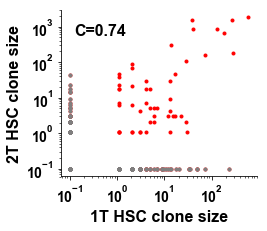

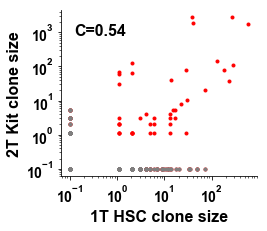

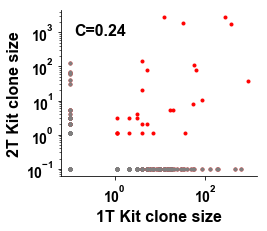

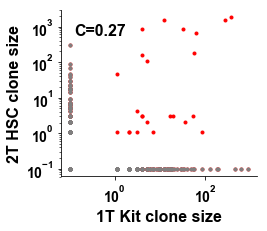

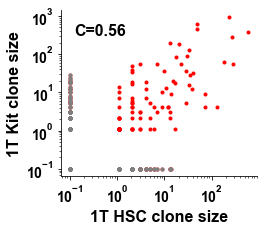

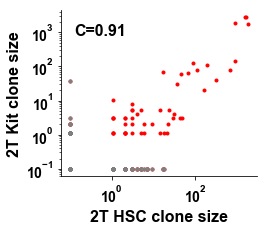

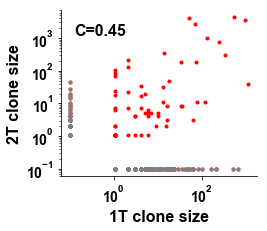

In [13]:
used_index=boolen_T1_or_T2;
plot_fig=[1,0]
result=hf.plot_figs_correlation(plot_fig,T1_HSC_info[used_index], T1_Kit_info[used_index], 
                                T2_HSC_info[used_index], T2_Kit_info[used_index], fig_dir);
    
corr_T1HSC_T2HSC=result[0]
corr_T1HSC_T2Kit=result[1]
corr_T1Kit_T2Kit=result[2]
corr_T1Kit_T2HSC=result[3]
corr_T1HSC_T1Kit=result[4]
corr_T2HSC_T2Kit=result[5]
corr_T1cloneT2clone=result[6]

In [14]:
# # if we renormalized the 2T clone size by the 1T HSC size, 
# # the correlation between 1T and 2T should be close to zero, as expectedby our model
# used_index=boolen_T1_or_T2;
# plot_fig=[1,0]
# result=hf.plot_figs_correlation_normalized(plot_fig,pseudo_act_exp,T1_HSC_info[used_index], T1_Kit_info[used_index], T2_HSC_info[used_index], T2_Kit_info[used_index], fig_dir);

## clone size correlation between R1 and R2

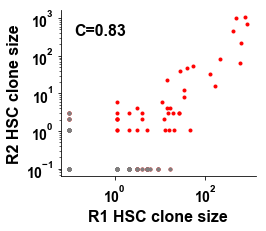

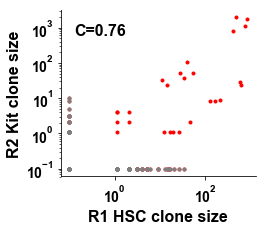

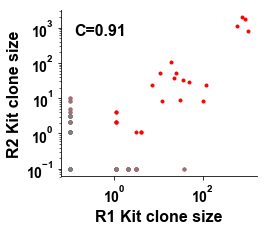

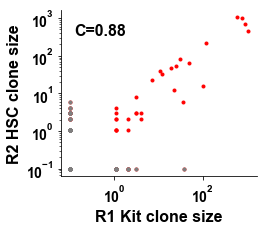

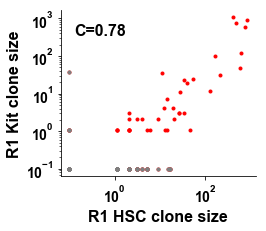

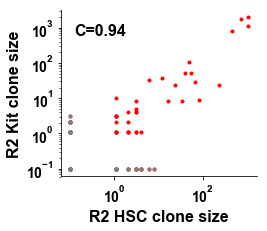

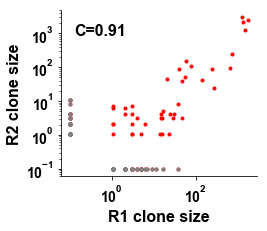

In [15]:
used_index=boolen_R1_or_R2;
plot_fig=[1,3]
result=hf.plot_figs_correlation(plot_fig,T2R1_HSC_info[used_index], T2R1_Kit_info[used_index], T2R2_HSC_info[used_index], T2R2_Kit_info[used_index], fig_dir);
    
corr_R1HSC_R2HSC=result[0]
corr_R1HSC_R2Kit=result[1]
corr_R1Kit_R2Kit=result[2]
corr_R1Kit_R2HSC=result[3]
corr_R1HSC_R1Kit=result[4]
corr_R2HSC_R2Kit=result[5]
corr_R1cloneR2clone=result[6]

Corr[R1 exp,R2 exp]: 0.6806294996358249


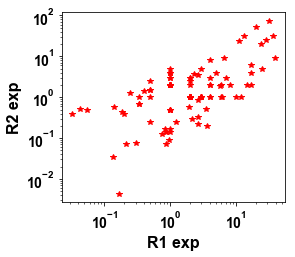

In [16]:
data1=expansion_R1[boolen_R1_or_R2];
data2=expansion_R2[boolen_R1_or_R2];
x_name="R1 exp"
y_name="R2 exp"

%run my_fig_config.py
plt.plot(data1,data2,'*r')
plt.xscale('log');plt.yscale('log')
ax.set_xlabel(x_name);ax.set_ylabel(y_name);

corr_R2exp_R2exp=pearsonr(data1,data2)[0];
print("Corr["+x_name+","+y_name+"]:",corr_R2exp_R2exp)

## Activity and expansion

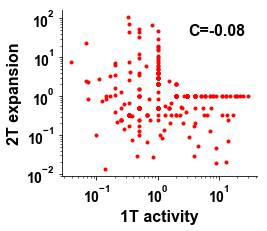

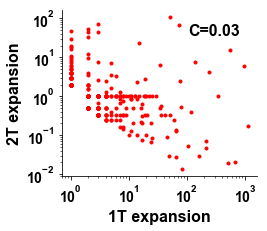

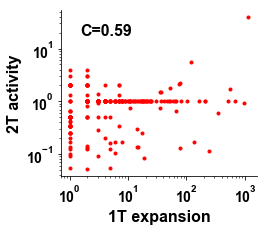

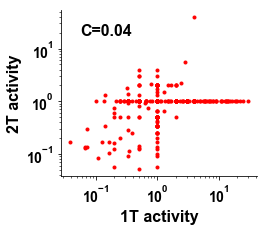

In [17]:
plot_fig=[1, 0]
used_index=boolen_T1_or_T2;
corr_ActExp=hf.plot_figs_expansion_activity(cutoff_small,cutoff_large, pseudo_act_exp,plot_fig, T1_HSC_info[used_index],
                                T1_Kit_info[used_index], T2_HSC_info[used_index], T2_Kit_info[used_index], fig_dir);

corr_T1actT2exp=corr_ActExp[0];
corr_T1expT2exp=corr_ActExp[1];
corr_T1expT2act=corr_ActExp[2];
corr_T1actT2act=corr_ActExp[3];

data points # for second class: 203
mean_1/mean_2 3.733909927511043
Std1/std2 35.8672020641015


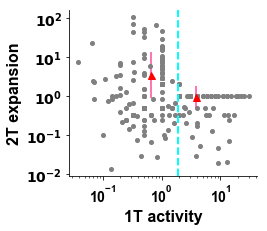

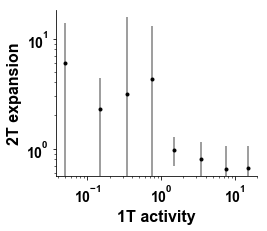

In [18]:
# 1T activity & 2T-R1 expansion
plot_fig=[1, 0]
used_index=boolen_T1_or_T2;
[mean_ratio_T1T2,std_ratio_T1T2]=hf.plot_figs_1Tactivity_2Texpansion(cutoff_small, pseudo_act_exp, threshold, plot_fig,
T1_HSC_info[used_index], T1_Kit_info[used_index], T2_HSC_info[used_index], T2_Kit_info[used_index], fig_dir)


mean ratio (1T-2T)[HSC] 2.5011372218986576
std ratio (1T-2T)[HSC] 19.045236265962387


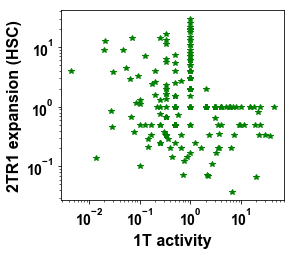

In [19]:
# statistical significance of T1 activity-T2R2 expansion relation
used_index=boolen_T1_or_T2;
data_x=expansion_HSC_T2[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_HSC_T1T2=np.mean(data_1)/np.mean(data_2);
std_ratio_HSC_T1T2=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR1 expansion (HSC)");

print("mean ratio (1T-2T)[HSC]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-2T)[HSC]",np.std(data_1)/np.std(data_2))

mean ratio (1T-2T)[Kit] 1.8822641964039764
std ratio (1T-2T)[Kit] 21.693532704022665


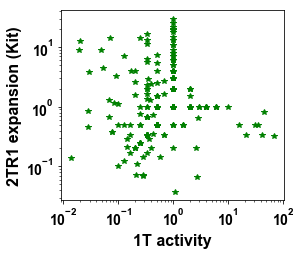

In [20]:
# statistical significance of T1 activity-T2R2 expansion relation
used_index=boolen_T1_or_T2;
data_x=expansion_Kit_T2[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_Kit_T1T2=np.mean(data_1)/np.mean(data_2);
std_ratio_Kit_T1T2=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR1 expansion (Kit)");

print("mean ratio (1T-2T)[Kit]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-2T)[Kit]",np.std(data_1)/np.std(data_2))

data points # for second class: 203
mean_1/mean_2 2.4715392711622477
Std1/std2 19.04386370128478


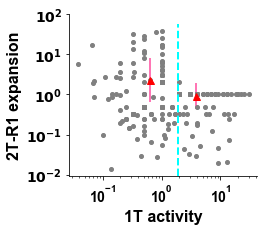

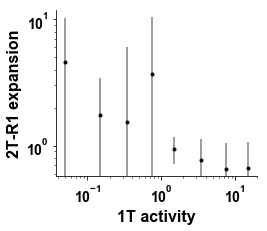

In [21]:
# 1T activity & 2T-R1 expansion
plot_fig=[1, 1]
used_index=boolen_T1_or_R1;
[mean_ratio_T1R1,std_ratio_T1R1]=hf.plot_figs_1Tactivity_2Texpansion(cutoff_small, pseudo_act_exp, threshold, plot_fig,
T1_HSC_info[used_index], T1_Kit_info[used_index], T2R1_HSC_info[used_index], T2R1_Kit_info[used_index], fig_dir)



mean ratio (1T-2TR1)[HSC] 1.9612975112086133
std ratio (1T-2TR1)[HSC] 13.152054653119858


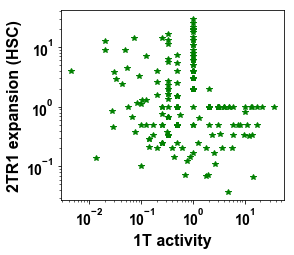

In [22]:
# statistical significance of T1 activity-T2R2 expansion relation
used_index=boolen_T1_or_R1;
data_x=expansion_HSC_R1[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_HSC_T1R1=np.mean(data_1)/np.mean(data_2);
std_ratio_HSC_T1R1=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR1 expansion (HSC)");

print("mean ratio (1T-2TR1)[HSC]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-2TR1)[HSC]",np.std(data_1)/np.std(data_2))

mean ratio (1T-2TR1)[Kit] 1.0718230262245172
std ratio (1T-2TR1)[Kit] 9.189501547684856


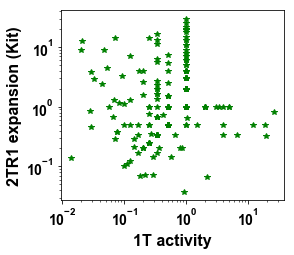

In [23]:
# statistical significance of T1 activity-T2R1 expansion relation
used_index=boolen_T1_or_R1;
data_x=expansion_Kit_R1[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_Kit_T1R1=np.mean(data_1)/np.mean(data_2);
std_ratio_Kit_T1R1=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR1 expansion (Kit)");

print("mean ratio (1T-2TR1)[Kit]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-2TR1)[Kit]",np.std(data_1)/np.std(data_2))

data points # for second class: 203
mean_1/mean_2 2.14211099395939
Std1/std2 23.634451757522893


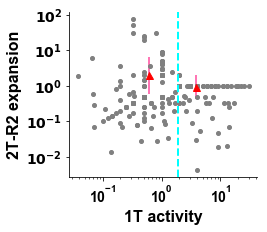

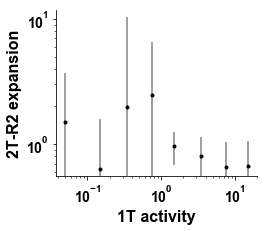

In [24]:
# 1T activity & 2T-R2 expansion
plot_fig=[1, 2]
used_index=boolen_T1_or_R2;
[mean_ratio_T1R2,std_ratio_T1R2]=hf.plot_figs_1Tactivity_2Texpansion(cutoff_small, pseudo_act_exp, threshold,plot_fig,
T1_HSC_info[used_index], T1_Kit_info[used_index], T2R2_HSC_info[used_index], T2R2_Kit_info[used_index], fig_dir)


mean ratio (1T-R2)[HSC] 1.2177652517647495
std ratio (1T-R2)[HSC] 9.371720803085449


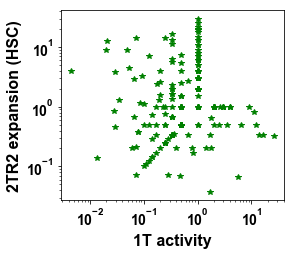

In [25]:
# statistical significance of T1 activity-T2R2 expansion relation
used_index=boolen_T1_or_R2;
data_x=expansion_HSC_R2[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_HSC_T1R2=np.mean(data_1)/np.mean(data_2);
std_ratio_HSC_T1R2=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR2 expansion (HSC)");

print("mean ratio (1T-R2)[HSC]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-R2)[HSC]",np.std(data_1)/np.std(data_2))

mean ratio (1T-R2)[Kit] 1.463080189908335
std ratio (1T-R2)[Kit] 15.44462110130294


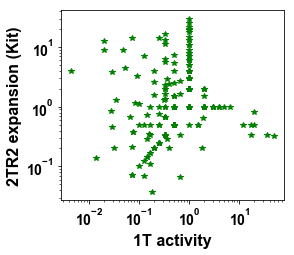

In [26]:
# statistical significance of T1 activity-T2R2 expansion relation
used_index=boolen_T1_or_R2;
data_x=expansion_Kit_R2[used_index];
data_y=activity_T1[used_index];
data_1=data_x[data_y<threshold]
data_2=data_x[data_y>=threshold]
mean_ratio_Kit_T1R2=np.mean(data_1)/np.mean(data_2);
std_ratio_Kit_T1R2=np.std(data_1)/np.std(data_2);

%run my_fig_config.py
plt.plot(data_x,data_y,'*g')
plt.xscale('log')
plt.yscale('log')
ax.set_xlabel("1T activity");
ax.set_ylabel("2TR2 expansion (Kit)");

print("mean ratio (1T-R2)[Kit]",np.mean(data_1)/np.mean(data_2))
print("std ratio (1T-R2)[Kit]",np.std(data_1)/np.std(data_2))

# save the data

In [27]:
# save the data in txt

with open(data_dir+"saved_data_BC_sequences.txt",'w') as file:
    file.write("Index\tSequence\n")
    for j, seq in enumerate(BC_seq):
        file.write(str(j)+"\t"+seq+"\n")
        
# with open(data_dir+"saved_data_shared_BC_sequences.txt",'w') as file:
#     file.write("Index\tSequence\n")
#     for j,seq in enumerate(BC_seq[0:shared_clone_N]):
#         file.write(str(j)+"\t"+seq+"\n")
        
# if analyze_sample_1=="T1_" and analyze_sample_2=="T2_": 
#     with open(data_dir+"saved_data_shared_BC_sequences_in_old_T1_clustering.txt",'w') as file:
#         file.write("Index\tSequence\n")
#         for j,seq in enumerate(shared_BC_seq_T1_old):
#             file.write(str(j)+"\t"+seq+"\n")
    
# with open(data_dir+"saved_data_BC_sequences") as file:
#     for seq in BC_sequence_info:
#         file.write(seq+"\n")

with open(data_dir+"saved_data_all_others.txt",'w') as file:
    file.write("Index\tT1\tT2\tT1-HSC\tT1-Kit\tT2R1-HSC\tT2R1-Kit\tT2R2-HSC\tT2R2-Kit\n")
    for j,seq in enumerate(BC_seq):
        file.write(str(j)+"\t"+str(T1_info[j])+"\t"+str(T2_info[j])\
                   +"\t"+str(T1_HSC_info[j])+"\t"+str(T1_Kit_info[j])+"\t"\
                   +str(T2R1_HSC_info[j])+"\t"+str(T2R1_Kit_info[j])+"\t"\
                   + str(T2R2_HSC_info[j])+"\t"+str(T2R2_Kit_info[j])+"\n")
        

In [28]:
# these data will be used for simulation

all_data=np.zeros((len(T1_info),6),dtype="int");
all_data[:,0]=T1_HSC_info;
all_data[:,1]=T1_Kit_info;
all_data[:,2]=T2R1_HSC_info;
all_data[:,3]=T2R1_Kit_info;
all_data[:,4]=T2R2_HSC_info;
all_data[:,5]=T2R2_Kit_info;
# all_data[:,6]=BCmap_shared[:,0]; # T1 index
# all_data[:,7]=BCmap_shared[:,1]; # T2-R1 index
# all_data[:,8]=BCmap_shared[:,2]; # T2-R2 index
np.save(data_dir+"all_data.npy",all_data);

In [29]:
# save variables in python file, will be used in simulation for computing p values
with open(data_dir+"corr_variables_etc.py",'w') as file:
    file.write("pseudo_act_exp={}\n".format(pseudo_act_exp));
    file.write("cutoff_small={}\n".format(cutoff_small));
    file.write("cutoff_large={}\n".format(cutoff_large));
    file.write("threshold={}\n".format(threshold))
    
    file.write("mean_ratio_T1T2={}\n".format(mean_ratio_T1T2));
    file.write("std_ratio_T1T2={}\n".format(std_ratio_T1T2));
    file.write("mean_ratio_HSC_T1T2={}\n".format(mean_ratio_HSC_T1T2));
    file.write("std_ratio_HSC_T1T2={}\n".format(std_ratio_HSC_T1T2));
    file.write("mean_ratio_Kit_T1T2={}\n".format(mean_ratio_Kit_T1T2));
    file.write("std_ratio_Kit_T1T2={}\n".format(std_ratio_Kit_T1T2));
    
    file.write("mean_ratio_T1R1={}\n".format(mean_ratio_T1R1));
    file.write("std_ratio_T1R1={}\n".format(std_ratio_T1R1));
    file.write("mean_ratio_HSC_T1R1={}\n".format(mean_ratio_HSC_T1R1));
    file.write("std_ratio_HSC_T1R1={}\n".format(std_ratio_HSC_T1R1));
    file.write("mean_ratio_Kit_T1R1={}\n".format(mean_ratio_Kit_T1R1));
    file.write("std_ratio_Kit_T1R1={}\n".format(std_ratio_Kit_T1R1));
    
    file.write("mean_ratio_T1R2={}\n".format(mean_ratio_T1R2));
    file.write("std_ratio_T1R2={}\n".format(std_ratio_T1R2));
    file.write("mean_ratio_HSC_T1R2={}\n".format(mean_ratio_HSC_T1R2));
    file.write("std_ratio_HSC_T1R2={}\n".format(std_ratio_HSC_T1R2));
    file.write("mean_ratio_Kit_T1R2={}\n".format(mean_ratio_Kit_T1R2));
    file.write("std_ratio_Kit_T1R2={}\n".format(std_ratio_Kit_T1R2));
    
    file.write("corr_T1HSC_T2HSC={}\n".format(corr_T1HSC_T2HSC));
    file.write("corr_T1HSC_T2Kit={}\n".format(corr_T1HSC_T2Kit));
    file.write("corr_T1Kit_T2Kit={}\n".format(corr_T1Kit_T2Kit));
    file.write("corr_T1Kit_T2HSC={}\n".format(corr_T1Kit_T2HSC));
    file.write("corr_T1HSC_T1Kit={}\n".format(corr_T1HSC_T1Kit));
    file.write("corr_T2HSC_T2Kit={}\n".format(corr_T2HSC_T2Kit));
    file.write("corr_T1cloneT2clone={}\n".format(corr_T1cloneT2clone));
    
    file.write("corr_R1HSC_R2HSC={}\n".format(corr_R1HSC_R2HSC));
    file.write("corr_R1HSC_R2Kit={}\n".format(corr_R1HSC_R2Kit));
    file.write("corr_R1Kit_R2Kit={}\n".format(corr_R1Kit_R2Kit));
    file.write("corr_R1Kit_R2HSC={}\n".format(corr_R1Kit_R2HSC));
    file.write("corr_R1HSC_R1Kit={}\n".format(corr_R1HSC_R1Kit));
    file.write("corr_R2HSC_R2Kit={}\n".format(corr_R2HSC_R2Kit));
    file.write("corr_R1cloneR2clone={}\n".format(corr_R1cloneR2clone));
    
    file.write("clone_N_T1={}\n".format(clone_N_T1));
    file.write("clone_N_T2={}\n".format(clone_N_T2));
    file.write("clone_N_T2R1={}\n".format(clone_N_T2_R1));
    file.write("clone_N_T2R2={}\n".format(clone_N_T2_R2));
    
    file.write("corr_T1actT2exp={}\n".format(corr_T1actT2exp));
    file.write("corr_T1expT2exp={}\n".format(corr_T1expT2exp));
    file.write("corr_T1expT2act={}\n".format(corr_T1expT2act));
    file.write("corr_T1actT2act={}\n".format(corr_T1actT2act));
    file.write("corr_R2exp_R2exp={}\n".format(corr_R2exp_R2exp));
    
    
    
    

In [30]:
clone_N_T2_R2

77